In [12]:
using Plots; pyplot();
using FFTW;
using LinearAlgebra;
using Random;
Random.seed!(100);

In [13]:
#  domain [0,Lx)\times [0,Ly)
Lx = 1.0; 
Ly = 2.0;

# number of resolved points in each direction
Nx = 32;
Ny = 64;

# consruct mesh, excluding last point
Δx = Lx/Nx;
Δy = Ly/Ny;

# Regular mesh
x = LinRange(0.0, Lx, Nx+1)[1:end-1];
y = LinRange(0.0, Ly, Ny+1)[1:end-1];

# construct wave numbers in correct layout
kx = [0:Int(Nx/2); -Int(Nx/2)+1:1:-1]; 
ky = [0:Int(Ny/2); -Int(Ny/2)+1:1:-1];


In [14]:
#Building functions for the forcing term and building exact solution analytically.
kkx = 1;
kky = 2;

f = (x,y) -> [sin(2*π/Lx *kkx * xx)*sin(2*π/Ly *kky * yy) for yy in y, xx in x];
f_noisy = (x,y,γ) -> [sin(2*π/Lx *kkx * xx)*sin(2*π/Ly *kky * yy) + γ^2 * randn(1)[1] for yy in y, xx in x];
u_exact = 1/( (2*π/Lx*kkx)^2 + (2*π/Ly *kky )^2 )* f(x,y);

In [15]:
function ThreeDVAR_update(u_oldvals,fvals,α,kx,ky)
    #applies the 3DVAR update and returns a new state u_new
    #u_oldvals and fvals are arrays of complex numbers corresponding to the current state and a noisy sample f of the forcing term.
    #α is the regularization parameter and kx,ky are wavenumbers
    
    #appling the fast fourier transform
    fhat = fft(fvals);
    u_oldhat = fft(u_oldvals);
    u_newhat = zeros(ComplexF64,(Ny,Nx));
    
    #applying the 3DVAR update in fourier space
    for j=1:Ny,i=1:Nx
        Ak = ( (2*π/Lx * kx[i])^2 + (2*π/Ly * ky[j])^2 );
        Sigmainv = Ak^(-2)
        if(i+j>2) 
           u_newhat[j,i]= (Ak.*fhat[j,i] + α.*Sigmainv.*u_oldhat[j,i]) ./ (Ak.^2 + α*Sigmainv);
        end
    end
    
    #applying the inverse fast fourier transform
    u_new = ifft(u_newhat);
    return u_new
end


ThreeDVAR_update (generic function with 1 method)

In [16]:
function run_simulation(num_samples, α, γ)
    #runs both 3DVAR and time averaged 3DVAR on the 2D Poisson problem,
    #returns solutions for the classic and time averaged problems and time series 2-norm errors.
    #num_samples is the number of samples to run, α is the regularization parameter and γ is the noise level.
    u_3DVAR = zeros(ComplexF64,(Ny,Nx));
    u_TA3DVAR = zeros(ComplexF64,(Ny,Nx));

    error_3DVAR=zeros(num_samples);
    error_TA3DVAR=zeros(num_samples);

    for j = 1:num_samples
        fvals = f_noisy(x,y,γ);
        u_3DVAR = ThreeDVAR_update(u_3DVAR,fvals,α,kx,ky); #applying update
        u_TA3DVAR = (j/(j+1))*u_TA3DVAR + (1/(j+1))*u_3DVAR; #updating time average
        
        #calculating errors
        error_3DVAR[j]=norm(u_3DVAR .-u_exact)*sqrt(Δx*Δy);
        error_TA3DVAR[j]=norm(u_TA3DVAR .-u_exact)*sqrt(Δx*Δy);
    end 
    return u_3DVAR, u_TA3DVAR, error_3DVAR, error_TA3DVAR
end


run_simulation (generic function with 1 method)

In [17]:
#Running simulation
num_samples = 100; α = 1; γ = 1;
u_3DVAR, u_TA3DVAR, error_3DVAR, error_TA3DVAR = run_simulation(num_samples, α, γ);

┌ Warning: Skipped yaxis arg loge
└ @ Plots C:\Users\Felix\.julia\packages\Plots\Iuc9S\src\axes.jl:83


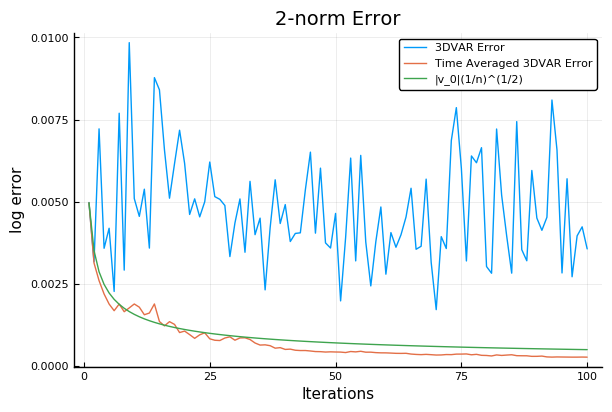

┌ Warning: Skipped yaxis arg loge
└ @ Plots C:\Users\Felix\.julia\packages\Plots\Iuc9S\src\axes.jl:83
┌ Warning: Skipped yaxis arg loge
└ @ Plots C:\Users\Felix\.julia\packages\Plots\Iuc9S\src\axes.jl:83


In [18]:
#Plotting errors
plot(1:num_samples, error_3DVAR, label="3DVAR Error",yaxis=(:loge))
plot!(1:num_samples, error_TA3DVAR, label="Time Averaged 3DVAR Error",yaxis=(:loge))
plot!(1:num_samples, (ones(num_samples)./((1:num_samples).^(1/2))).*error_TA3DVAR[1], label="|v_0|(1/n)^(1/2)",yaxis=(:loge))
title!("2-norm Error")
xlabel!("Iterations")
ylabel!("log error")
savefig("err")

In [19]:
#running a shorter simulation and then plotting solutions
num_samples = 10; α = 1; γ = 1;
u_3DVAR, u_TA3DVAR, error_3DVAR, error_TA3DVAR = run_simulation(num_samples, α, γ);

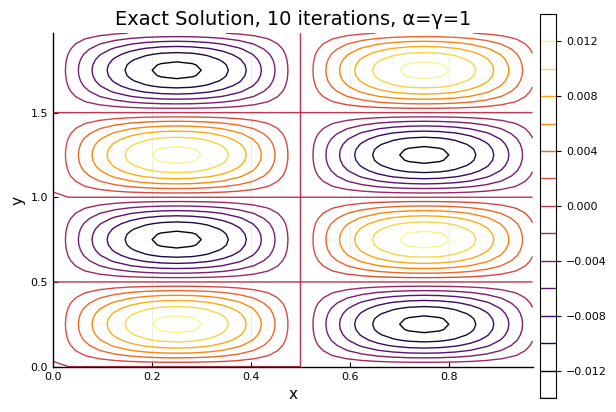

In [20]:
contour(x,y,u_exact)
title!("Exact Solution, 10 iterations, α=γ=1")
xlabel!("x")
ylabel!("y")
savefig("u_exact")

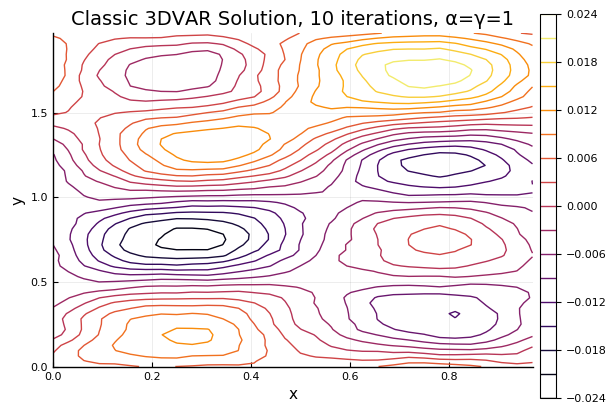

In [21]:
contour(x,y,real(u_3DVAR))
title!("Classic 3DVAR Solution, 10 iterations, α=γ=1")
xlabel!("x")
ylabel!("y")
savefig("u_3DVAR")

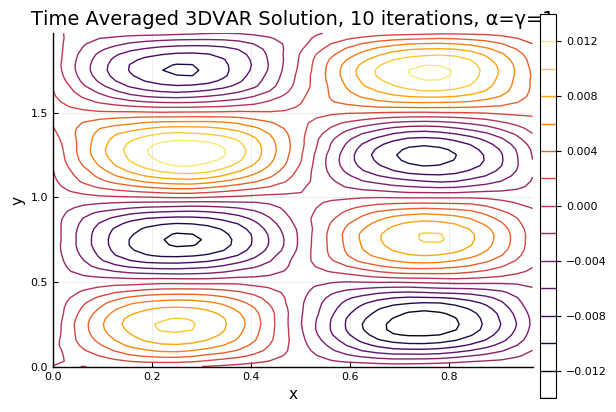

In [22]:
contour(x,y,real(u_TA3DVAR))
title!("Time Averaged 3DVAR Solution, 10 iterations, α=γ=1")
xlabel!("x")
ylabel!("y")
savefig("u_TA3DVAR")